# Practical Session - GAN

The goal of this exercice is to create a DCGAN to generate Manga faces.

## Roadline :

- Setup the workspace
  1. Enable the **GPU**
  2. Install and import the **Pytorch library**
- DCGAN implementation in Pytorch explained 0. Import libraries needed
  1. Load and Prepare dataset
  2. Generator
  3. Discriminator
  4. Generator - Discriminator Loss
  5. Optimizer
  6. Train


## Setup the workplace


1. Enable the **GPU**

Getting Starting, you need to **enable** the GPU as hardware accelerator :

             »Edit »Notebook settings »select GPU » SAVE.

and check the GPU type :


In [1]:
!nvidia-smi

Wed Mar 15 10:53:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
| N/A   61C    P8    N/A /  N/A |      5MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

2. **install** and **import** the _PyTorch library_


In [2]:
#!pip3 install torch torchvision
import torch


## DCGAN implementation in Pytorch


### 0. Libraries importation

For this project, we need to import several packages


In [3]:
import glob
import os
import random
import time

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from IPython import display
from IPython.display import HTML
from PIL import Image
from torch.utils.data import Dataset
from torchvision.utils import make_grid


### 1. Load and Prepare dataset


1. Download the Manga face dataset by cloning the github project of Yaohui Wang

2. and then unzip the images folder

3. To take a look at the dataset, display the image you want and the associated size

4. Prepare the loaded MangaFace dataset as training set

5. Show the size of the training set


In [6]:
# 1) download dataset
!git submodule add https://gitlab.inria.fr/yaowang/gan_class_images.git

Cloning into '/media/joris/uca-msc-dsai/dl_computer_vision/practice/gan_class_images'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Receiving objects: 100% (3/3), 111.92 MiB | 1.01 MiB/s, done.


In [8]:
!cd gan_class_images

In [9]:
# 2) cd images folder and unzip 
!cd gan_class_images;unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/7053.jpg         
  inflating: images/30207.jpg        
  inflating: images/3853.jpg         
  inflating: images/11662.jpg        
  inflating: images/21884.jpg        
  inflating: images/31911.jpg        
  inflating: images/4856.jpg         
  inflating: images/14119.jpg        
  inflating: images/35640.jpg        
  inflating: images/16345.jpg        
  inflating: images/7751.jpg         
  inflating: images/1498.jpg         
  inflating: images/12330.jpg        
  inflating: images/5852.jpg         
  inflating: images/34104.jpg        
  inflating: images/24623.jpg        
  inflating: images/27201.jpg        
  inflating: images/23837.jpg        
  inflating: images/8489.jpg         
  inflating: images/11448.jpg        
  inflating: images/599.jpg          
  inflating: images/10744.jpg        
  inflating: images/25495.jpg        
  inflating: images/34808.jpg        
  inflating: images/26689.jpg        
  inflat

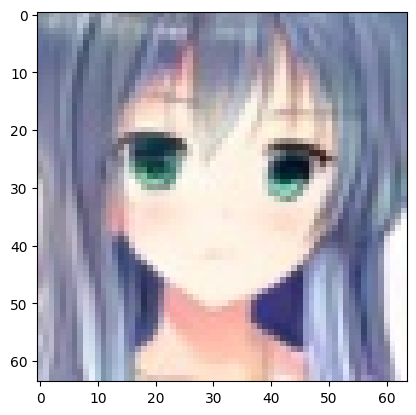

(64, 64, 3)


In [10]:
# 3) Display one image in the training set and the associated size
# We here chose to display

# image1 = 34985.jpg
image1 = plt.imread("gan_class_images/images/822.jpg")
plt.imshow(image1)
plt.show()
print(image1.shape)

# image2 = 240.jpg


In [11]:
# 4) Prepare the MangaFace Dataset as training set with the help of *class*


class MangaFace(Dataset):
  def __init__(self, root, transform=None):
    """Initialize Pokemon."""
    self.transform = transform
    self.root = root
    self.imgs = glob.glob(self.root + "*")

  def __getitem__(self, idx):
    """Get item from Pokemon class.
    Args:
        index (int): Index
    Returns:
        img: PIL Image.
    """
    img = self.imgs[idx]
    img = Image.open(img).convert("RGB")

    if self.transform is not None:
      img = self.transform(img)

    return img

  def __len__(self):
    """Get length."""
    return len(self.imgs)


In [ ]:
# 5) Show the size of the training set

# normalize all image included on the loaded dataset :
train_transform = transforms.Compose(
  [
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ]
)

# Define the trainset thanks to MangaFace :
trainset = MangaFace(root="./gan_class_images/images/", transform=train_transform)

# Show the size :
print("Size of the training set : ", len(trainset))


Size of the training set :  36740


### Define Generator and Discriminator networks

Preliminary work :

1. Define parameters

2. Set device - using GPU

3. Network weights initialization


In [ ]:
# 1) Define parameters

batch_size = 128  # or other 64, 32
beta1 = 0.5  # for the optimization function
lr = 2e-4  # learning rate
nz = 100  # input dimension
num_epochs = 100  # trainings
num_workers = 8


In [ ]:
# 2) Set device - we use GPU
device = torch.device("cuda:0")


In [ ]:
# 3) Network weights initialization
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find("Conv") != -1:
    m.weight.data.normal_(0.0, 0.02)  # N(0,0.02)
  elif classname.find("BatchNorm") != -1:
    m.weight.data.normal_(1.0, 0.02)  # N(1,0.02)
    m.bias.data.fill_(0)


### 2. Generator Network

For this project :

> input size: batchsize _ 100 _ 1 \* 1

> output size: batchsize _ 3 _ 64 \* 64

In oder to generate image from the input noise, we use the operator **ConvTranspose2d** to upsample spatial dimension :

    nn.ConvTranspose2d(in-channels , out-channels, kernel-size, stride, padding)

1. Define the Generator Network

2. Test the Generator


In [ ]:
# Summary of the generator :
"""
* 1st layer:
transposed convolution
batch norm
relu

* 2nd layer
transposed convolution
batch norm
relu

* 3rd layer
transposed convolution
batch norm
relu

* 4th layer
transposed convolution
batch norm
relu

* 5th layer
transposed convolution
tanh
"""


# 1) Define the Generator Network
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # TODO:

    # input = bs * 100 * 1 * 1
    # output = bs * 3 * 64 * 64

    # Help of the Sequential module
    self.net = nn.Sequential(
      # 1st layer output: bs * 512 * 4 * 4
      nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=True),
      nn.BatchNorm2d(512),
      nn.ReLU(inplace=True),
      # 2nd layer output: bs * 256 * 8 * 8
      nn.ConvTranspose2d(512, 256, 4, 2, 1),
      nn.BatchNorm2d(256),
      nn.ReLU(inplace=True),
      # 3rd layer output: bs * 128 * 16 * 16
      nn.ConvTranspose2d(256, 128, 4, 2, 1),
      nn.BatchNorm2d(128),
      nn.ReLU(True),
      # 4th layer output: bs * 64 * 32 * 32
      nn.ConvTranspose2d(128, 64, 4, 2, 1),
      nn.BatchNorm2d(64),
      nn.ReLU(True),
      # 5th layer output: bs * 3 * 64 * 64
      nn.ConvTranspose2d(64, 3, 4, 2, 1),
      nn.Tanh(),
    )

  def forward(self, x):

    out = self.net(x)

    return out


In [ ]:
net = Generator()
print(net)


Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)


In [ ]:
# 2) Test the Generator
# input : 8 tensor with 100 channels of 1x1
z = torch.randn(8, 100, 1, 1)

net = Generator()
# output through the Generator "net" : 8 tensor with 3 channels (RGB) of 64x64
out = net(z)  # 8 * 3 * 64 * 64

# shape of the out through the Generator ?
print(out.shape)


torch.Size([8, 3, 64, 64])


### 2. Discriminator Network

The discriminator take as input a real data or a generated data and perform a binary classification.

> input size: batchsize _ 3 _ 64 \* 64

> output size: batchsize \* 1

1. Define the Discriminator Network

2. Test the Discriminator


In [ ]:
# Summary of the discriminator :
"""
* 1st layer:
convolution
Leakyrelu

* 2nd layer
convolution
batch norm
Leakyrelu

* 3rd layer
convolution
batch norm
Leakyrelu

* 4th layer
convolution
batch norm
Leakyrelu

* 5th layer
convolution
sigmoid
"""


# 1) Define the Discriminator Network


class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.net = nn.Sequential(
      # 1st layer output: bs * 64 * 32 * 32
      nn.Conv2d(3, 64, 4, 2, 1),
      # nn.ReLU(True),
      nn.LeakyReLU(0.2, True),
      # 2nd layer output: bs * 128 * 16 * 16
      nn.Conv2d(64, 128, 4, 2, 1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2, True),
      # 3rd layer output: bs * 256 * 8 * 8
      nn.Conv2d(128, 256, 4, 2, 1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2, True),
      # 4th layer output: bs * 512 * 4 * 4
      nn.Conv2d(256, 512, 4, 2, 1),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2, True),
      # 5th layer output: bs * 1
      nn.Conv2d(512, 1, 4, 1, 0),
      nn.Sigmoid(),
    )

  def forward(self, x):

    out = self.net(x)

    return out.squeeze(-1).squeeze(-1)


In [ ]:
# 2) Test the Discriminator
# input : 4 tensor with 3 channels of 64x64
x = torch.randn(4, 3, 64, 64)

net = Discriminator()
# output through the Discriminator "net" :
out = net(x)
print(out.size())  # 4 * 1


torch.Size([4, 1])


### Display Function


In [ ]:
def display_demos(fixed_noise, epoch, iters):
  img_list = []
  with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    plt.rcParams["figure.figsize"] = 10, 10
    plt.clf()
    plt.title("epoch: %d iteration: %d" % (epoch, iters))
    imgs = make_grid(fake.data * 0.5 + 0.5).cpu()  # CHW
    plt.imshow(imgs.permute(1, 2, 0).numpy())
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)


### Main for G and D


In [ ]:
# define G, D and initialize parameters
# attention: put it into GPU
netG = Generator().to(device)
netD = Discriminator().to(device)
netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

### 4. Generator - Discriminator Loss


In [ ]:
# define loss function
# hint: binary cross entropy
criterion = nn.BCELoss().to(device)


In [ ]:
# img_list for loss
G_losses = []
D_losses = []
iters = 0


### 5. Optimizer


In [ ]:
# Create batch of latent vectors (64 * nz * 1 * 1) that we will use to visualize
# hint: torch.randn
fixed_noise = torch.randn(64, 100, 1, 1).to(device)


In [ ]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


### 6. Train


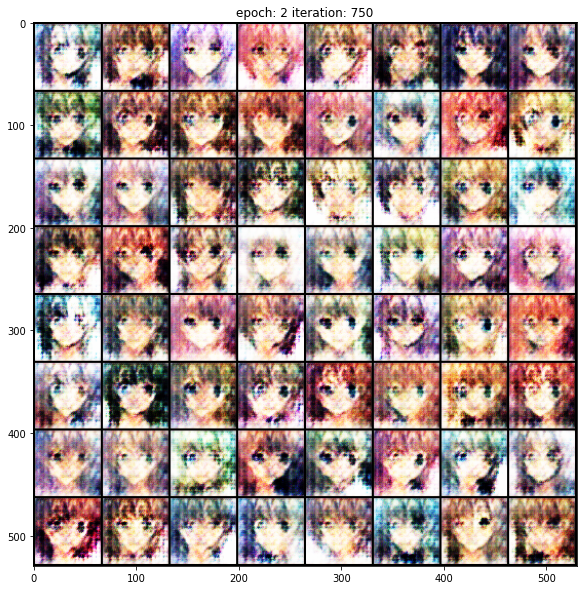

In [ ]:
dataset = MangaFace(root="./gan_class_images/images/", transform=train_transform)
dataloader = torch.utils.data.DataLoader(
  dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)


print("==> start training")
for epoch in range(num_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(dataloader):
    ############################
    # Update D network
    # maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # put data into gpu
    real_imgs = data.to(device)

    ## Train with all-real batches
    # set D gradient 0
    netD.zero_grad()

    # Forward pass real batch through D
    output = netD(real_imgs)

    # set ground truth label 1
    label_real = torch.ones(output.size()).to(device)

    # Calculate loss on all-real batch
    errD_real = criterion(output, label_real)

    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noises = torch.randn(output.size(0), 100, 1, 1).to(device)

    # Generate fake image batch with G
    fake = netG(noises)

    # Classify all fake batch with D
    output = netD(fake.detach())

    # set ground truth label 0
    label_fake = torch.zeros(output.size()).to(device)

    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label_fake)

    # Calculate the gradients for this batch
    errD_fake.backward()

    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake

    # Update D
    optimizerD.step()

    ############################
    # Update G network
    # maximize log(D(G(z)))
    ###########################
    # set G gradient 0
    netG.zero_grad()

    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake)

    # Calculate G's loss based on this output
    errG = criterion(output, label_real)

    # Calculate gradients for G
    errG.backward()

    # Update G
    optimizerG.step()

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # display demo images each 50 iterations
    if iters % 50 == 0:
      display_demos(fixed_noise, epoch, iters)

    iters += 1


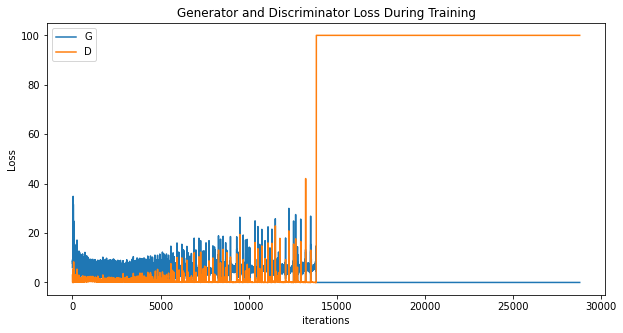

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
